## Presentation about Coral data for Charlie

Seaview Survey Photo-quadrat and Image Classification Dataset 

#### Data provider
The data is provided by the _XL Catlin Seaview Survey Project_ that was developped as a collaboration between the University of Queensland and ocean conservaton non-profit Underwater Earth.


The goal of their project is to collect rapid, detailed, globally distributed scientific surveys of coral reefs to support research and conservation.
The data colletion took part between 2012-2018 with a custom camera that produced high quality photographs of the reef at transect that were usually 1.5-2 km long. Images were taken between 0.5-2m to ensure constistent spatial resolution (around 10 pixels/cm).


#### Data specifics
The raw data is a collection of over one million images covering around 1m² of the sea floor. You also have human-classified annotations that may be used to train and validate image classifiers.
Deep learning algorithms (VGG-D 16 network architecture) were used to estimate the benthic cover from each photo. The relative abundance of each benthic group was also estimated by using deep learning algorithms.

For this project we are interested in the benthic cover of the corals derived from the images and we will thus not focus on the images. 

#### Data sets used
The "seaviewsurvey_surveys.csv", contains **the proportional cover of reef cover** between _hard_ or _soft_ corals, _other invertebrates_ or _other_ or algea. 
It also has "lat_start, lng_start", the latitude and longitude of start of survey but also the end "lat_end, lng_end". 

The "seaviewsurvey_reefcover_Australia.csv" contains summary classification data for each photo, represented as **a percent cover**. Here we get the proportional cover of the specified class name within the photo-quadrat. It is thus more specific than the previous one. The file also contains the latitude and longitude of the photo quadrat for easy spotage. The survey id is also given which we can then link with the other data sets. 





In [2]:
# Import useful packages

import gdal
import pandas as pd
import geopandas as gpd
from io import StringIO
import osr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Import the csv data with percentage of hard, soft corals, other inverterbrates and other things 
Survey = pd.read_csv("../Data/seaviewsurvey_surveys.csv")
Survey.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [5]:
# Keep only Australia as country 
Survey_AUS = Survey[Survey["country"] == "AUS"]
# Make the integers "surveydate" as a real time frame 
Survey_AUS['surveydate'] = pd.to_datetime(Survey_AUS['surveydate'], format='%Y%m%d')
Survey_AUS.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [7]:
# Import the more precise benthic cover data
Benthic = pd.read_csv("../Data/seaviewsurvey_reefcover_pacificaustralia.csv")
Benthic.head()

,surveyid,imageid,quadratid,lat,lng,ACR-BRA,ACR-HIP,ACR-OTH,ACR-PE,ACR-TCD,...,OTH-SF,OTH-SINV,POCI,POR-BRA,POR-ENC,POR-MASS,Sand,Turf,Turfsa,Unc
0,10001,100010007,10001000701,-16.189056,145.898116,0.0,0.0,0.0,0.0,0.02,...,0.72,0.00,0.02,0.0,0.02,0.00,0.00,0.0,0.0,0.02
1,10001,100010007,10001000702,-16.189056,145.898116,0.0,0.0,0.0,0.0,0.06,...,0.68,0.04,0.02,0.0,0.12,0.00,0.02,0.0,0.0,0.02
2,10001,100010008,10001000801,-16.189075,145.898118,0.0,0.0,0.0,0.0,0.22,...,0.64,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0,0.00
3,10001,100010008,10001000802,-16.189075,145.898118,0.0,0.0,0.0,0.0,0.02,...,0.60,0.00,0.00,0.0,0.10,0.02,0.00,0.0,0.0,0.00
4,10001,100010008,10001000803,-16.189075,145.898118,0.0,0.0,0.0,0.0,0.00,...,0.72,0.00,0.00,0.0,0.12,0.00,0.12,0.0,0.0,0.00


<AxesSubplot:>

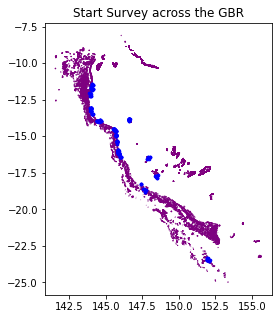

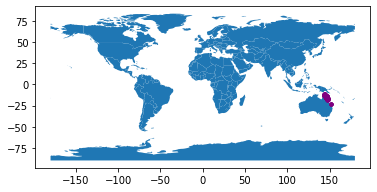

In [19]:
# Map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Data frame with start survey coordinates 
gSurvey = gpd.GeoDataFrame(Survey_AUS, geometry = gpd.points_from_xy(Survey_AUS.lng_start, Survey_AUS.lat_start))

# Map of GBR
shx = gpd.read_file("../Data/Reefs/Reefs_GBR.shx")
ax = shx.plot(figsize=(15, 5), edgecolor='purple')
ax.set_title("Start Survey across the GBR")

# Plot the survey points on the GBR map
gSurvey.plot(ax = ax, color = 'blue',markersize=7)

# Plot the survey points on the world map
ax_world = world.plot()
gSurvey.plot(ax = ax_world, color = 'purple',markersize=7)

In [63]:
Survey_AUS.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,geometry
0,10001,10001,2012-09-16,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700,POINT (145.89810 -16.18902)
1,10002,10002,2012-09-17,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771,POINT (145.89825 -16.18930)
2,10003,10003,2012-09-18,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917,POINT (145.89168 -16.17577)
3,10004,10004,2012-09-20,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748,POINT (147.80680 -16.53665)
4,10005,10005,2012-09-20,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201,POINT (147.80258 -16.52922)


In [47]:
# Take the mean of the percentage cover
def mean_col(df, col_name):
    return df[col_name].mean()
mean_hard_coral = mean_col(Survey_AUS, "pr_hard_coral")
mean_soft_coral = mean_col(Survey_AUS, "pr_soft_coral")
mean_algae_coral = mean_col(Survey_AUS, "pr_algae")
mean_oth_inv_coral = mean_col(Survey_AUS, "pr_oth_invert")
mean_oth_coral = mean_col(Survey_AUS, "pr_other")
mean_spec = pd.DataFrame({'Mean': [mean_hard_coral, mean_soft_coral, mean_algae_coral, mean_oth_inv_coral, mean_oth_coral]},index=["pr_hard_coral", "pr_soft_coral","pr_algae", "pr_oth_invert", "pr_other"])

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:ylabel='Mean'>

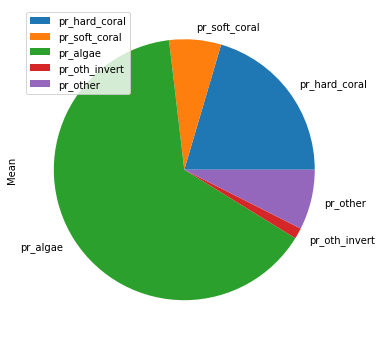

In [52]:
# Plot the means as pie plot 
mean_spec.plot.pie(y = "Mean", figsize=(11, 6))

In [83]:
Survey_AUS["surveydate"].dt.year.value_counts().reset_index()

,index,surveydate
0,2012,118
1,2016,60
2,2014,48
3,2017,35


<AxesSubplot:ylabel='Frequency'>

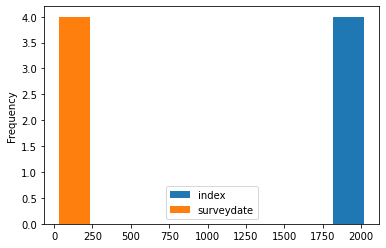

In [84]:
Survey_AUS["surveydate"].dt.year.value_counts().reset_index().plot.hist(by="surveydate")